**Author:** Prof. AJ Smit

Department of Biodiversity and Conservation Biology

University of the Western Cape

# Topic 3: A deeper dive into gradients

In the previous two sections we looked at calculations involving biodiversity (specifically the dissimilarity matricies made from a species table) and environmental variables (distances). What can we do with the two forms of contemporary β-diversity? What do they mean? Can we look to environmental distances for more insight? 

Let's do a deeper analysis and create a figure to demonstrate these findings. I regress $\beta_{\text{sør}}$ on the spatial distance between section pairs (see below) and on the environmental distance ($\beta_{\text{E}}$) in each bioregion and used the magnitude of the slope (per 100 km) of this relationship as a metric of β-diversity or ‘distance decay’ of dissimilarity.

What these lines of code do is regreate Figure 5 in Smit et al. (2017). Please read the paper for an interpretation of this figure as this is critical for an understanding of the role that gradients play in structuring patterns of biodiversity.

(To be updated...)

## Setting up the analysis environment

In [1]:
library(plyr)
library(vegan)
library(betapart) # for partitioning beta-diversity
library(BiodiversityR) # for calcs of species richness etc.
library(tidyr)
library(ggplot2)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: tcltk

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

BiodiversityR 2.13-1: Use command BiodiversityRGUI() to launch the Graphical User Interface; 
to see changes use BiodiversityRGUI(changeLog=TRUE, backward.compatibility.messages=TRUE)




## Load all of the data

In [2]:
# load the environmental data:
load("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/SeaweedEnv.RData")
env <- as.data.frame(env)
env <- env[, c("annMean", "annRange", "annSD", "febMean", "febRange", "febSD", "augMean", "augRange", "augSD")] # keep only some...

Since the connectivity between sections is constrained by their location along a shoreline, we calculated the distances between sections not as ‘as the crow flies’ distances (e.g. Section 1 is not connected in a straight line to Section 58 because of the intervening land in-between), but as the great circle geodesic distances between each pair of sections along a ‘route’. Traveling from **1** to **58** therefore requires visiting **2**, then **3**, and eventually all the way up to **58**. The total distance between a pair of arbitrary sections is thus the cumulative sum of the great circle distances between each consecutive pair of intervening sections along the route. These data are contained in `dists_mat.RData` (I prepared it earlier):

In [19]:
load("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/dists_mat.RData") # loads as dists.mat
dists.mat[1:10, 1:10]

,1,2,3,4,5,6,7,8,9,10
1,0.000,51.138,104.443,153.042,207.386,253.246,305.606,359.799,409.263,457.857
2,51.138,0.000,53.305,101.904,156.248,202.108,254.468,308.661,358.125,406.719
3,104.443,53.305,0.000,48.599,102.943,148.803,201.163,255.356,304.820,353.414
4,153.042,101.904,48.599,0.000,54.344,100.204,152.564,206.757,256.221,304.815
5,207.386,156.248,102.943,54.344,0.000,45.860,98.220,152.413,201.877,250.471
6,253.246,202.108,148.803,100.204,45.860,0.000,52.360,106.553,156.017,204.611
7,305.606,254.468,201.163,152.564,98.220,52.360,0.000,54.193,103.657,152.251
8,359.799,308.661,255.356,206.757,152.413,106.553,54.193,0.000,49.464,98.058
9,409.263,358.125,304.820,256.221,201.877,156.017,103.657,49.464,0.000,48.594
10,457.857,406.719,353.414,304.815,250.471,204.611,152.251,98.058,48.594,0.000


Various bioregions have been defined for South African marine biota. I prefer to use the one made by John Bolton and Herre Stegenga in 2002:

In [21]:
bioreg <- read.csv('/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/bioregions.csv', header = TRUE)
rbind(head(bioreg, 3), tail(bioreg, 3))

,spal.prov,spal.ecoreg,lombard,bolton
,<chr>,<chr>,<chr>,<chr>
1,BMP,NE,NamBR,BMP
2,BMP,NE,NamBR,BMP
3,BMP,NE,NamBR,BMP
56,AMP,NE,NBR,ECTZ
57,AMP,NE,NBR,ECTZ
58,AMP,NE,NBR,ECTZ


Make a copy of the original matrix of distances between pairs of sites to create a full matrix which constrains pairwise comparisons to pairs within bioregions:

In [30]:
bioreg.mat <- dists.mat
bioreg.mat[1:58, 1:58] <- "out"
bioreg.mat[1:16, 1:16] <- "BMP"
bioreg.mat[17:21, 17:21] <- "B-ATZ"
bioreg.mat[22:41, 22:41] <- "AMP"
bioreg.mat[42:58, 42:58] <- "ECTZ"
dim(bioreg.mat) # print output below

# see what is inside the matrix... not printed here due to space constraints
bioreg.mat[1:3, 1:10] # print output below
bioreg.mat[56:58, 53:58] # print output below

# convert to show only the lower left triangle
bioreg.tri <- gdata::lowerTriangle(bioreg.mat, diag = FALSE) # requires the gdata package

[1] 58 58

,1,2,3,4,5,6,7,8,9,10
1,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP
2,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP
3,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP,BMP


,53,54,55,56,57,58
56,ECTZ,ECTZ,ECTZ,ECTZ,ECTZ,ECTZ
57,ECTZ,ECTZ,ECTZ,ECTZ,ECTZ,ECTZ
58,ECTZ,ECTZ,ECTZ,ECTZ,ECTZ,ECTZ


In `bioreg.mat`, pairs of sites that do not fall within any of the bioregions is called 'out':

In [31]:
bioreg.mat[1:3, 53:58] # print output below

,53,54,55,56,57,58
1,out,out,out,out,out,out
2,out,out,out,out,out,out
3,out,out,out,out,out,out


We extract the slices (groups of rows) of the original species table into separate dataframes, one for each of the four bioregions:

In [32]:
env.BMP <- env[1:16, ]
env.BATZ <- env[17:21, ]
env.AMP <- env[22:41, ]
env.ECTZ <- env[42:58, ]

Now we make an environmental dataframe for use with plots of pairwise correlations etc.:

In [28]:
env.df <- data.frame(bio = bioreg$bolton, round(env, 3))
rbind(head(env.df, 3), tail(env.df, 3))

,bio,annMean,annRange,annSD,febMean,febRange,febSD,augMean,augRange,augSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BMP,12.335,1.249,1.255,13.001,6.070,1.626,11.752,2.502,0.767
2,BMP,12.388,1.802,1.402,13.379,5.889,1.754,11.577,2.973,0.897
3,BMP,12.243,2.068,1.475,13.362,5.431,1.704,11.294,3.084,0.941
56,ECTZ,23.729,4.609,1.942,26.227,3.474,1.191,21.618,2.163,0.663
57,ECTZ,24.710,4.969,1.976,27.328,3.372,1.143,22.359,1.584,0.499
58,ECTZ,25.571,5.574,2.023,28.457,3.267,1.000,22.883,1.098,0.349


In [33]:
# load the seaweed data:
spp <- read.csv('/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/SeaweedsSpp.csv')
spp <- dplyr::select(spp, -1) # because it clashes with select from MASS

## Start calculating

Calculate beta-diversity using the Sørensen index of dissimilarity. This is used throughout; binary Bray-Curtis is equivalent to Sørensen in **vegan**.

In [8]:
# ---- Sorensen-index ----
Y <- vegdist(spp, binary = TRUE) # this is used throughout
Y.mat <- as.matrix(Y)
Y.diag <- diag(Y.mat[-1, -nrow(Y.mat)]) # extract the subdiagonal
Y.diag <- append(0, Y.diag, after = 1) # add a zero in front

Decompose into turnover and nestedness-resultant beta-diversity:

In [9]:
# ---- do-betapart ----
## Calculations with betapart:
Y.core <- betapart.core(spp)

# Using the Sørensen index, compute three distance matrices accounting for the (i) turnover (replacement),
# (ii) nestedness-resultant component, and (iii) total dissimilarity (i.e. the sum of both components):
Y.pair <- beta.pair(Y.core, index.family = "sor") # use for pairwise plotting

Extract the subdiagonal for plotting later on:

In [10]:
Y1.mat <- as.matrix(Y.pair$beta.sim)
Y1.diag <- diag(Y1.mat  [-1, -nrow(Y1.mat)]) # extract the subdiagonal
Y1.diag <- append(0, Y1.diag, after = 1) # add a zero in front

Y2.mat <- as.matrix(Y.pair$beta.sne)
Y2.diag <- diag(Y2.mat[-1, -nrow(Y2.mat)]) # extract the subdiagonal
Y2.diag <- append(0, Y2.diag, after = 1) # add a zero in front

Create separate matrices for each bioregion:

In [11]:
# ---- spp-bioregion ----
spp.BMP <- spp[1:16, ]
Y.BMP <- vegdist(spp.BMP, binary = TRUE)
spp.core.BMP <- betapart.core(spp.BMP)
Y.pair.BMP <- beta.pair(spp.core.BMP, index.family = "sor") # use for pairwise plotting

spp.BATZ <- spp[17:21, ]
Y.BATZ <- vegdist(spp.BATZ, binary = TRUE)
spp.core.BATZ <- betapart.core(spp.BATZ)
Y.pair.BATZ <- beta.pair(spp.core.BATZ, index.family = "sor") # use for pairwise plotting

spp.AMP <- spp[22:41, ]
Y.AMP <- vegdist(spp.AMP, binary = TRUE)
spp.core.AMP <- betapart.core(spp.AMP)
Y.pair.AMP <- beta.pair(spp.core.AMP, index.family = "sor") # use for pairwise plotting

spp.ECTZ <- spp[42:58, ]
Y.ECTZ <- vegdist(spp.ECTZ, binary = TRUE)
spp.core.ECTZ <- betapart.core(spp.ECTZ)
Y.pair.ECTZ <- beta.pair(spp.core.ECTZ, index.family = "sor") # use for pairwise plotting

Calculate species richness (alpha-diversity):

In [12]:
# ---- do-species-richness ----
spp.richness.site <- diversityresult(spp, index = 'richness', method = 'each site')

Calculate the environmental distances:

In [13]:
# ---- environmental-distance ----
# Euclidian distances on temperatures:
env.raw <- env # first make a copy so we can use untransformed data later on
env <- decostand(env, method = "standardize") # calculate z-scores

Using individual thermal variables, calculate Euclidian distances, make a matrix and extract the subdiagonal. The data have already been standardised in `env`:

In [14]:
# augMean
env4 <- dplyr::select(env, augMean) # as used in env.rda2
env4 <- vegdist(env4, method = 'euclidian')
env4.mat <- as.matrix(env4)
env4.diag <- diag(env4.mat[-1, -nrow(env4.mat)])
env4.diag <- append(0, env4.diag, after = 1)

In [15]:
# febRange:
env5 <- dplyr::select(env, febRange) # as used in env.rda2
env5 <- vegdist(env5, method = 'euclidian')
env5.mat <- as.matrix(env5)
env5.diag <- diag(env5.mat[-1, -nrow(env5.mat)])
env5.diag <- append(0, env5.diag, after = 1)

In [16]:
# febSD:
env6 <- dplyr::select(env, febSD) # as used in env.rda2
env6 <- vegdist(env6, method = 'euclidian')
env6.mat <- as.matrix(env6)
env6.diag <- diag(env6.mat[-1, -nrow(env6.mat)])
env6.diag <- append(0, env6.diag, after = 1)

In [17]:
# augSD:
env7 <- dplyr::select(env, augSD) # as used in env.rda2
env7 <- vegdist(env7, method = 'euclidian')
env7.mat <- as.matrix(env7)
env7.diag <- diag(env7.mat[-1, -nrow(env7.mat)])
env7.diag <- append(0, env7.diag, after = 1)

In [18]:
# annMean:
env8 <- dplyr::select(env, annMean) # as used in env.rda2
env8 <- vegdist(env8, method = 'euclidian')
env8.mat <- as.matrix(env8)
env8.diag <- diag(env8.mat[-1, -nrow(env8.mat)])
env8.diag <- append(0, env8.diag, after = 1)

In [19]:
# combined variables selected with the db-RDA:
# these have a far poorer fit...
env.comb <- dplyr::select(env, augMean, febRange, febSD, augSD)
env.comb <- vegdist(env.comb, method = 'euclidian')
env.comb.mat <- as.matrix(env.comb)
env.comb.diag <- diag(env.comb.mat[-1, -nrow(env.comb.mat)])
env.comb.diag <- append(0, env.comb.diag, after = 1)

In [20]:
# ---- do-figure-5 ----
# Assemble data frame for plotting:
spp.df <- data.frame(dist = as.vector(dists.mat),
                     bio = as.vector(bioreg.mat),
                     augMean = as.vector(env4.mat),
                     febRange = as.vector(env5.mat),
                     febSD = as.vector(env6.mat),
                     augSD = as.vector(env7.mat),
                     annMean = as.vector(env8.mat),
                     Y = as.vector(Y.mat),
                     Y1 = as.vector(Y1.mat),
                     Y2 = as.vector(Y2.mat))

Do the various linear regressions of Sørensen dissimilarities (*β~sor~*), turnover (*β~sim~*) and nestedness-related *β*-diversity (*β~sne~*) as a function of the various thermal distances. I only display the results of the linear regression for $Y1$ regressed on geographical distance, `dist`, but do all the calculations:

In [21]:
spp.df2 <- droplevels(subset(spp.df, bio !=  "out"))
head(spp.df2)

# turnover...
Y1.lm1 <- dlply(spp.df2, .(bio), function(x) lm(Y1 ~ dist, data = x))
lapply(Y1.lm1, summary)
Y1.lm2 <- dlply(spp.df2, .(bio), function(x) lm(Y1 ~ augMean , data = x))
# lapply(Y1.lm2, summary)
Y1.lm3 <- dlply(spp.df2, .(bio), function(x) lm(Y1 ~ augSD , data = x))
# lapply(Y1.lm3, summary)
Y1.lm4 <- dlply(spp.df2, .(bio), function(x) lm(Y1 ~ febRange , data = x))
# lapply(Y1.lm4, summary)
Y1.lm5 <- dlply(spp.df2, .(bio), function(x) lm(Y1 ~ febSD , data = x))
# lapply(Y1.lm5, summary)

# nestedness-resultant...
Y2.lm1 <- dlply(spp.df2, .(bio), function(x) lm(Y2 ~ dist, data = x))
# lapply(Y2.lm1, summary)
Y2.lm2 <- dlply(spp.df2, .(bio), function(x) lm(Y2 ~ annMean , data = x))
# lapply(Y2.lm2, summary)

,dist,bio,augMean,febRange,febSD,augSD,annMean,Y,Y1,Y2
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000,BMP,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.0000000000,0.0000000000,0.0000000000
2,51.138,BMP,0.057413686,0.098844037,0.162952710,0.31327996,0.015018458,0.0036101083,0.0000000000,0.0036101083
3,104.443,BMP,0.150439037,0.348877544,0.099341627,0.41882390,0.026022466,0.0036101083,0.0000000000,0.0036101083
4,153.042,BMP,0.203224406,0.557654418,0.040720995,0.41525879,0.051341700,0.0071942446,0.0000000000,0.0071942446
5,207.386,BMP,0.169908896,0.596480756,0.138250544,0.45110735,0.110354710,0.0249110320,0.0072463768,0.0176646552
6,253.246,BMP,0.082131062,0.506493762,0.158074740,0.50536019,0.141115516,0.0391459075,0.0217391304,0.0174067770


$AMP

Call:
lm(formula = Y1 ~ dist, data = x)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0595754 -0.0195099 -0.0045457  0.0150607  0.0676548 

Coefficients:
               Estimate  Std. Error t value Pr(>|t|)    
(Intercept) -5.1753e-03  2.4057e-03 -2.1513  0.03205 *  
dist         2.9388e-04  6.5671e-06 44.7508  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.027858 on 398 degrees of freedom
Multiple R-squared:  0.83421,	Adjusted R-squared:  0.83379 
F-statistic: 2002.6 on 1 and 398 DF,  p-value: < 2.22e-16


$`B-ATZ`

Call:
lm(formula = Y1 ~ dist, data = x)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.070629 -0.024865  0.008058  0.022698  0.059443 

Coefficients:
               Estimate  Std. Error t value  Pr(>|t|)    
(Intercept) -0.00805800  0.01364463 -0.5906    0.5606    
dist         0.00109279  0.00015899  6.8732 5.229e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

## Make the plots

Now assemble **Figure 5.** It is a plot of pairwise (a) Sørensen dissimilarities (*β~sor~*), (b) turnover (*β~sim~*) and (c) nestedness-related *β*-diversity (*β~sne~*) (*sensu* Baselga, 2010) as a function of distance between sections. Section pairs falling within individual bioregions are colour-coded; where the pairs include sections across different bioregions the symbols are coloured grey and labeled ‘out’.

Combine the data in a way that makes for easy plotting:

In [22]:
# Plots:
spp.long <- spp.df %>%
  gather(beta, dissim, Y:Y2) %>%
  gather(metric, distance, c(dist, augMean:annMean))
spp.long$metric = factor(spp.long$metric, levels = c('dist','augMean','febRange','febSD', 'augSD', 'annMean'))

The repetive portions of code needed to create each of the panels. I was too lazy to write neater and more concise code:

In [23]:
# sim as a function of geographic distance:
plt5a <- spp.long %>%
  dplyr::filter(beta %in% "Y1" & metric %in% "dist") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(name = "Bioregion", values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(name = "Bioregion", palette = "Set1") +
  scale_shape_manual(name = "Bioregion", values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(name = "Bioregion", values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(name = "Bioregion", values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste("Distance (km)"))) +
  ylab(expression(paste(beta[sim]))) +
  scale_y_continuous(limits = c(0, 0.75)) +
  scale_x_continuous(limits = c(0, 1000)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        # legend.position = c(0.2, 0.7),
        # legend.direction = "vertical",
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sim], " as a function of distance")))

In [24]:
# sim as a function of augMean:
plt5b <- spp.long %>%
  dplyr::filter(beta %in% "Y1" & metric %in% "augMean") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  # geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(palette = "Set1") +
  scale_shape_manual(values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste(d[E]))) +
  ylab(expression(paste(beta[sim]))) +
  scale_y_continuous(limits = c(0, 0.75)) +
  scale_x_continuous(limits = c(0, 2)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        legend.position = "none",
        # legend.title = element_blank(),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 8),
        legend.key = element_blank(),
        legend.key.height = unit(.22, "cm"),
        legend.background = element_blank(),
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sim], " as a function of augMean")))

In [25]:
# sim as a function of febRange:
plt5c <- spp.long %>%
  dplyr::filter(beta %in% "Y1" & metric %in% "febRange") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  # geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(palette = "Set1") +
  scale_shape_manual(values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste(d[E]))) +
  ylab(expression(paste(beta[sim]))) +
  scale_y_continuous(limits = c(0, 0.75)) +
  scale_x_continuous(limits = c(0, 4)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        legend.position = "none",
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sim], " as a function of febRange")))

In [26]:
# sim as a function of febSD:
plt5d <- spp.long %>%
  dplyr::filter(beta %in% "Y1" & metric %in% "febSD") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  # geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(palette = "Set1") +
  scale_shape_manual(values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste(d[E]))) +
  ylab(expression(paste(beta[sim]))) +
  scale_y_continuous(limits = c(0, 0.75)) +
  scale_x_continuous(limits = c(0, 3)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        legend.position = "none",
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sim], " as a function of febSD")))

In [27]:
# sim as a function of augSD:
plt5e <- spp.long %>%
  dplyr::filter(beta %in% "Y1" & metric %in% "augSD") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  # geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(palette = "Set1") +
  scale_shape_manual(values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste(d[E]))) +
  ylab(expression(paste(beta[sim]))) +
  scale_y_continuous(limits = c(0, 0.75)) +
  scale_x_continuous(limits = c(0, 3)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        legend.position = "none",
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sim], " as a function of augSD")))

In [28]:
# sne as a function of distance:
plt5f <- spp.long %>%
  dplyr::filter(beta %in% "Y2" & metric %in% "dist") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  # geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(palette = "Set1") +
  scale_shape_manual(values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste("Distance (km)"))) +
  ylab(expression(paste(beta[sne]))) +
  scale_y_continuous(limits = c(0, 0.22)) +
  scale_x_continuous(limits = c(0, 1000)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        legend.position = "none",
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sne], " as a function of distance")))

In [29]:
# sne as a function of annMean:
plt5g <- spp.long %>%
  dplyr::filter(beta %in% "Y2" & metric %in% "annMean") %>%
  ggplot(aes(x = distance, y = dissim, group = bio)) +
  geom_point(aes(colour = bio, shape = bio), size = 1.2, alpha = 0.8) +
  # geom_point(aes(colour = bio, size = bio, alpha = bio, shape = bio)) +
  geom_line(stat = "smooth", method = "lm", formula = y~x, alpha = 1.0, size = 0.6,
            colour = "black",
            aes(linetype = bio)) +
  scale_linetype_manual(values = c("dashed", "solid", "dotted", "longdash", "blank")) +
  scale_colour_brewer(palette = "Set1") +
  scale_shape_manual(values = c(0, 19, 2, 5, 46)) +
  scale_size_manual(values = c(1.0, 1.2, 1.0, 1.0, 0.6)) +
  scale_alpha_manual(values = c(0.85, 1.0, 0.85, 0.85, 0.1)) +
  xlab(expression(paste(d[E]))) +
  ylab(expression(paste(beta[sne]))) +
  scale_y_continuous(limits = c(0, 0.22)) +
  scale_x_continuous(limits = c(0, 2)) +
  theme_grey() +
  theme(panel.grid.minor = element_line(colour = NA),
        plot.title = element_text(hjust = 0, size = 10),
        legend.position = "none",
        aspect.ratio = 0.6) +
  ggtitle(expression(paste(beta[sne], " as a function of annMean")))

In [30]:
plt5h <- ggplot(spp.long, aes(x = distance, y = dissim)) + geom_blank() +
  theme(plot.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.line = element_blank())

Assemble using the **cowplot** package:

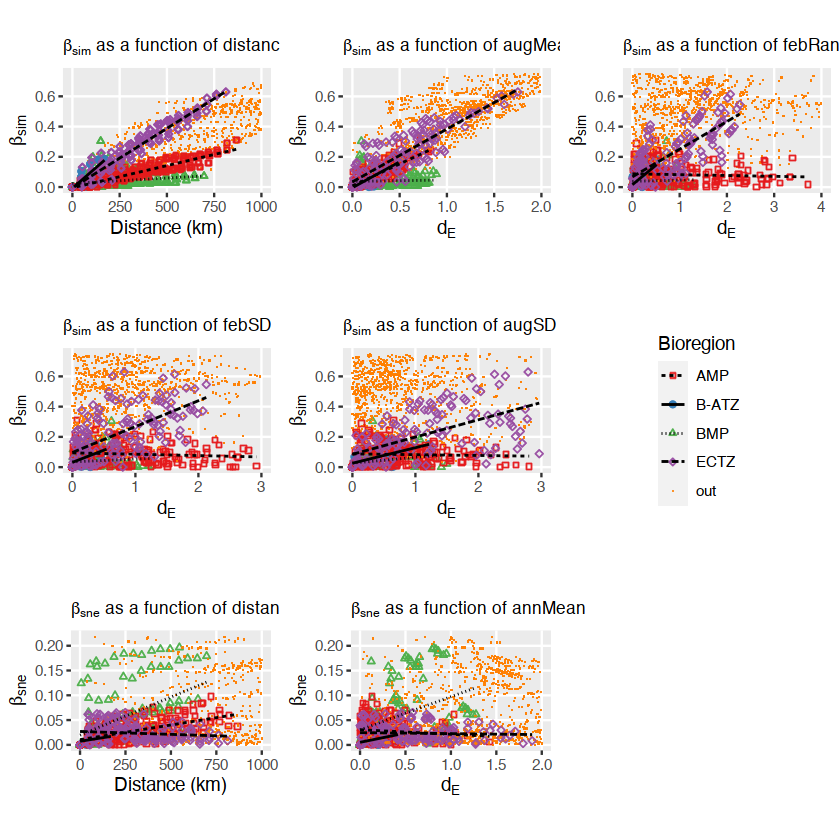

In [31]:
library(cowplot)

oldw <- getOption("warn") # turn off warnings
options(warn = -1)

l <- get_legend(plt5a)
# pdf("Fig5.pdf", width = 9, height = 6.5)
ggdraw() +
  draw_plot(plot_grid(plt5a + theme(legend.position = 'none'), plt5b, plt5c,
                      plt5d, plt5e, l,
                      plt5f, plt5g, plt5h,
                      ncol = 3, align = 'hv'),
            width = 1.0)
# dev.off()

options(warn = oldw)

# References

Baselga, A. (2010). Partitioning the turnover and nestedness components of beta diversity. Global Ecology and Biogeography 19, 134–143.

Bolton, J. J., and Stegenga, H. (2002). Seaweed species diversity in South Africa. South African Journal of Marine Science 24, 9–18.

Smit, A. J., Bolton, J. J., & Anderson, R. J. (2017). Seaweeds in two oceans: beta-diversity. Frontiers in Marine Science, 4, 404.